## Next Steps

1) Transform categorical data to numerical data where there is an ordinal ranking. Also check this visually with boxplots. This can be done by simply ordering the values before transforming them.
<br>
2) Can some of those values be grouped together based on ANOVA and boxplots?
<br>
3) Does it make sense to remove some one-hot columns that are largely made up of 0s? This can also be done for those that don't exist in test set.
<br>
4) Should I scale the numeric values including SalePrice? SalePrice would have to be scaled back before submitting.
<br>
5) ~~Use GridSearchCV to tune paramters. Also check out this: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/.~~ **Tuning worked for LarsLasso and Lasso but was not better than XGBoost settings**
<br>
6) Explore more models like: https://www.kdnuggets.com/2018/03/catboost-vs-light-gbm-vs-xgboost.html. Also go trough scikit library. What about ExtraTrees etc.
<br>
7) Feature Engineering. Test out FeatureTools, come up with my own and check other Kaggle kernels for ideas.
<br>
8) ~~Test out different combinations of stacking models. And also different ratios.~~ **I gave this a shot. So far the three models with equal weights have produced the best results**
<br>
9) Plot residuals to see where errors occur: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

# 1) Read in the Modules

In [1]:
# Import the modules

import pandas as pd
import numpy as np
#from scipy import stats
import sklearn as sk
#import itertools

# Data Vis
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep') 
import matplotlib.style as style
style.use('fivethirtyeight')


from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV

from scipy.stats import skew

# Data Scaler
from sklearn.preprocessing import StandardScaler

# Regression
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# 2) Load Data and Initial Inspection

## 2.1) Load Data and Quality Checks

**We should try to keep training and test data separate so as not to influence our decisions by the test data, which should be used to test the generalisation of the model and therefore needs to remain 'unseen'. This also applies to the imputation of Null values.**

In [2]:
train = pd.read_csv('C:/Users/akosciansky/Desktop/Kaggle/Ames Housing Dataset/train.csv')
test = pd.read_csv('C:/Users/akosciansky/Desktop/Kaggle/Ames Housing Dataset/test.csv')

In [3]:
# Change the settings so that you can see all columns of the dataframe when calling df.head()
pd.set_option('display.max_columns',999)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Get the shape of the data

print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [5]:
# Check that all columns in test also exist in train apart from SalePrice, which is the target variable

train.columns.drop('SalePrice') == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [6]:
# Check that the data types in train are the same as in test

a = np.array(train.drop('SalePrice', axis='columns').columns[train.drop('SalePrice', axis='columns').dtypes != test.dtypes])
a

array(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea'],
      dtype=object)

**The difference between test and training data is that a couple of variables are integers in one and float numbers in another. I will go with float numbers for both**

In [7]:
train[a].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 8 columns):
BsmtFinSF1      1460 non-null int64
BsmtFinSF2      1460 non-null int64
BsmtUnfSF       1460 non-null int64
TotalBsmtSF     1460 non-null int64
BsmtFullBath    1460 non-null int64
BsmtHalfBath    1460 non-null int64
GarageCars      1460 non-null int64
GarageArea      1460 non-null int64
dtypes: int64(8)
memory usage: 91.3 KB


In [8]:
test[a].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 8 columns):
BsmtFinSF1      1458 non-null float64
BsmtFinSF2      1458 non-null float64
BsmtUnfSF       1458 non-null float64
TotalBsmtSF     1458 non-null float64
BsmtFullBath    1457 non-null float64
BsmtHalfBath    1457 non-null float64
GarageCars      1458 non-null float64
GarageArea      1458 non-null float64
dtypes: float64(8)
memory usage: 91.3 KB


## 2.2) Initial Data Inspection

**Let's get an initial idea of what variables we are dealing with, whether they contain missing data, and what their distribution looks like.**

In [9]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

**Let's visualise the missing data for both train and test set**

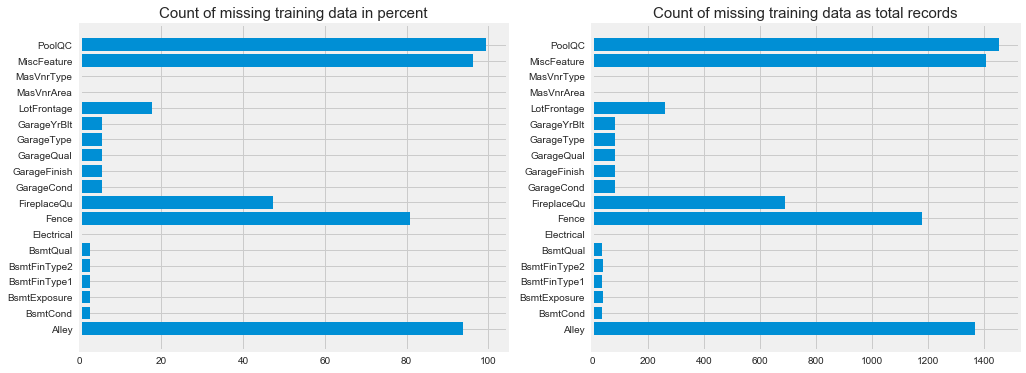

In [11]:
# Capture the necessary data
variables = train.columns

count = []

for variable in variables:
    length = train[variable].count()
    count.append(length)
    
count_pct = np.round(100 * pd.Series(count) / len(train), 2)
count = pd.Series(count)

missing = pd.DataFrame()
missing['variables'] = variables
missing['count'] = len(train) - count
missing['count_pct'] = 100 - count_pct
missing = missing[missing['count_pct'] > 0]
missing.sort_values(by=['count_pct'], inplace=True)
missing_train = np.array(missing['variables'])

#Plot number of available data per variable
plt.subplots(figsize=(15,6))

# Plots missing data in percentage
plt.subplot(1,2,1)
plt.barh(missing['variables'], missing['count_pct'])
plt.title('Count of missing training data in percent', fontsize=15)

# Plots total row number of missing data
plt.subplot(1,2,2)
plt.barh(missing['variables'], missing['count'])
plt.title('Count of missing training data as total records', fontsize=15)

plt.show()

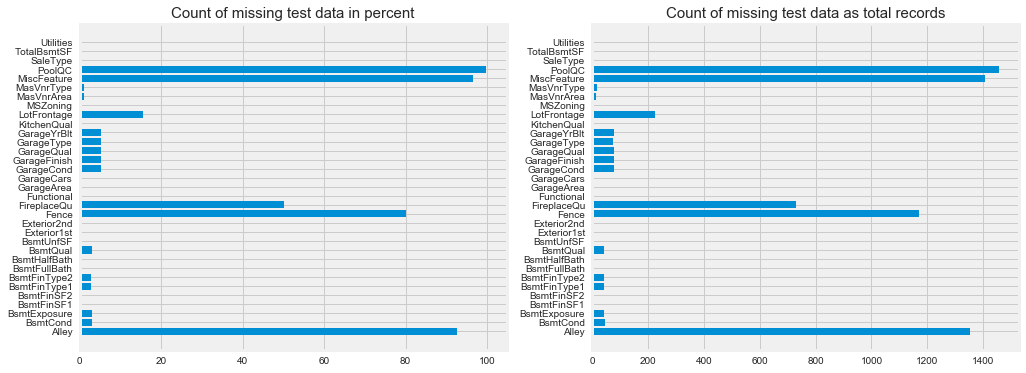

In [12]:
# Capture the necessary data
variables = test.columns

count = []

for variable in variables:
    length = test[variable].count()
    count.append(length)
    
count_pct = np.round(100 * pd.Series(count) / len(test), 2)
count = pd.Series(count)

missing = pd.DataFrame()
missing['variables'] = variables
missing['count'] = len(test) - count
missing['count_pct'] = 100 - count_pct
missing = missing[missing['count_pct'] > 0]
missing.sort_values(by=['count_pct'], inplace=True)
missing_test = np.array(missing['variables'])

#Plot number of available data per variable
plt.subplots(figsize=(15,6))

# Plots missing data in percentage
plt.subplot(1,2,1)
plt.barh(missing['variables'], missing['count_pct'])
plt.title('Count of missing test data in percent', fontsize=15)

# Plots total row number of missing data
plt.subplot(1,2,2)
plt.barh(missing['variables'], missing['count'])
plt.title('Count of missing test data as total records', fontsize=15)

plt.show()

**Attributes like PoolQC and MiscFeatures have a lot of missing data in both training and test set and it might be neccessary to drop them.
<br>
On the other hand, a lot of the NULL values might not be missing data but it was simply not applicable. For example, if there is no pool then there cannot be any pool quality.
<br>
This is indeed the case when looking at the data dictionary and I will convert the values in the next section.**

In [13]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [14]:
test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1381.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,442.898624,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,26.431175,0.775945,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


## 2.3) Data Cleaning - dealing with missing data and incorrect data types

### 2.3.1) Change Data Types

**To Objects**

In [15]:
# Convert training data
train['MSSubClass'] = train['MSSubClass'].astype('object')
train['MoSold'] = train['MoSold'].astype('object')

# Convert test data
test['MSSubClass'] = test['MSSubClass'].astype('object')
test['MoSold'] = test['MoSold'].astype('object')

**To numeric** - for simplicity I convert everything to float

In [16]:
# Convert training data
numeric_train = train.select_dtypes(include=[np.number]).columns.tolist()
train[numeric_train] = train[numeric_train].astype('float64')

# Convert test data
numeric_test = test.select_dtypes(include=[np.number]).columns.tolist()
test[numeric_test] = test[numeric_test].astype('float64')

### 2.3.2) Get a list of variables that will be adjusted

**In this step I get all variables that I will adjust and save them so that they are more easily accessible**

**Get list of variables that are objects or numerics and whose NULL values will be overridden**

In [17]:
#Exclude features with no NULL values

drop_object = ['Functional', 'SaleType', 'Exterior1st', 'Exterior2nd']
drop_numeric = ['GarageYrBlt']


train_object = train.columns[(train.dtypes == 'object') & (train.columns.isin(missing_train))]
test_object = test.columns[(test.dtypes == 'object') & (test.columns.isin(missing_test))].drop(drop_object)

train_numeric = train.columns[(train.dtypes != 'object') & (train.columns.isin(missing_train))].drop(drop_numeric) # if the garage was never build then we can't impute a date
test_numeric = test.columns[(test.dtypes != 'object') & (test.columns.isin(missing_test))].drop(drop_numeric)

**Get list of variables that can be imputed**

In [18]:
#train_object_impute = train[['Electrical', 'Utilities', 'MSZoning', 'KitchenQual', 'Exterior1st']].columns
test_object_impute = test[['Electrical', 'Utilities', 'MSZoning', 'KitchenQual', 'Exterior1st']].columns

### 2.3.5) Impute Null values

In [19]:
# These are variables where it makes sense to impute them rather than setting them to 0 or 'Other'
# As they are categorical values I need to use the mode instead of the mean or median

# Impute training data
#for variable in train_object_impute:
#    train[variable] = train[variable].fillna(train[variable].mode()[0])

# Impute test data
for variable in test_object_impute:
    test[variable] = test[variable].fillna(test[variable].mode()[0])

### 2.3.3) Non-Numerical Data: Overwriting Nulls with 'Missing'

Now I will overwrite all non-numerical data with whatever the appropriate 'Missing' value is, which can be 'None', 'Other' etc.

In [20]:
# Get the non-numerical variables apart from 'Functional', 'SaleType', 'Exterior1st', 'Exterior2nd' as they get
# different values according to the data dictionary

for variable in train_object:
    train[variable] = train[variable].fillna('None')
    
train['Functional'] = train['Functional'].fillna('Typ') 
train['SaleType'] = train['SaleType'].fillna('Oth')
#train['Exterior1st'] = train['Exterior1st'].fillna('Other')
train['Exterior2nd'] = train['Exterior2nd'].fillna('Other')

# Do the same thing for test now

for variable in test_object:
    test[variable] = test[variable].fillna('None')
    
test['Functional'] = test['Functional'].fillna('Typ') 
test['SaleType'] = test['SaleType'].fillna('Oth')
#test['Exterior1st'] = test['Exterior1st'].fillna('Other')
test['Exterior2nd'] = test['Exterior2nd'].fillna('Other')

### 2.3.4) Numerical Data: Overwrite Nulls to 0

In [21]:
# Get numerical values apart from GarageYrBlt, which can't be imputed if it was neer built. However if GarageCars or 
# GarageArea have positive values then I can impute GarageYrBlt 

for variable in train_numeric:
    train[variable] = train[variable].fillna(0)
    
for variable in test_numeric:
    test[variable] = test[variable].fillna(0)

There are roughly 80 GarageYrBlt values missing in both train and test - I am not sure how to impute those.

# EDA needs to be updated - have box-whisker plots and bar plots for categorical & histograms for numerical data. The bar plot helps deciding whether an attribute should be dropped and the combination of barplot and box-whisker plot helps decided whether categories within a variable should be merged. The histogram helps decide whether a numerical variable needs to be transformed.

## 2.4.1) Analyse Object Data

In [22]:
# Get quantitative variables
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')

# Get qualitative data
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

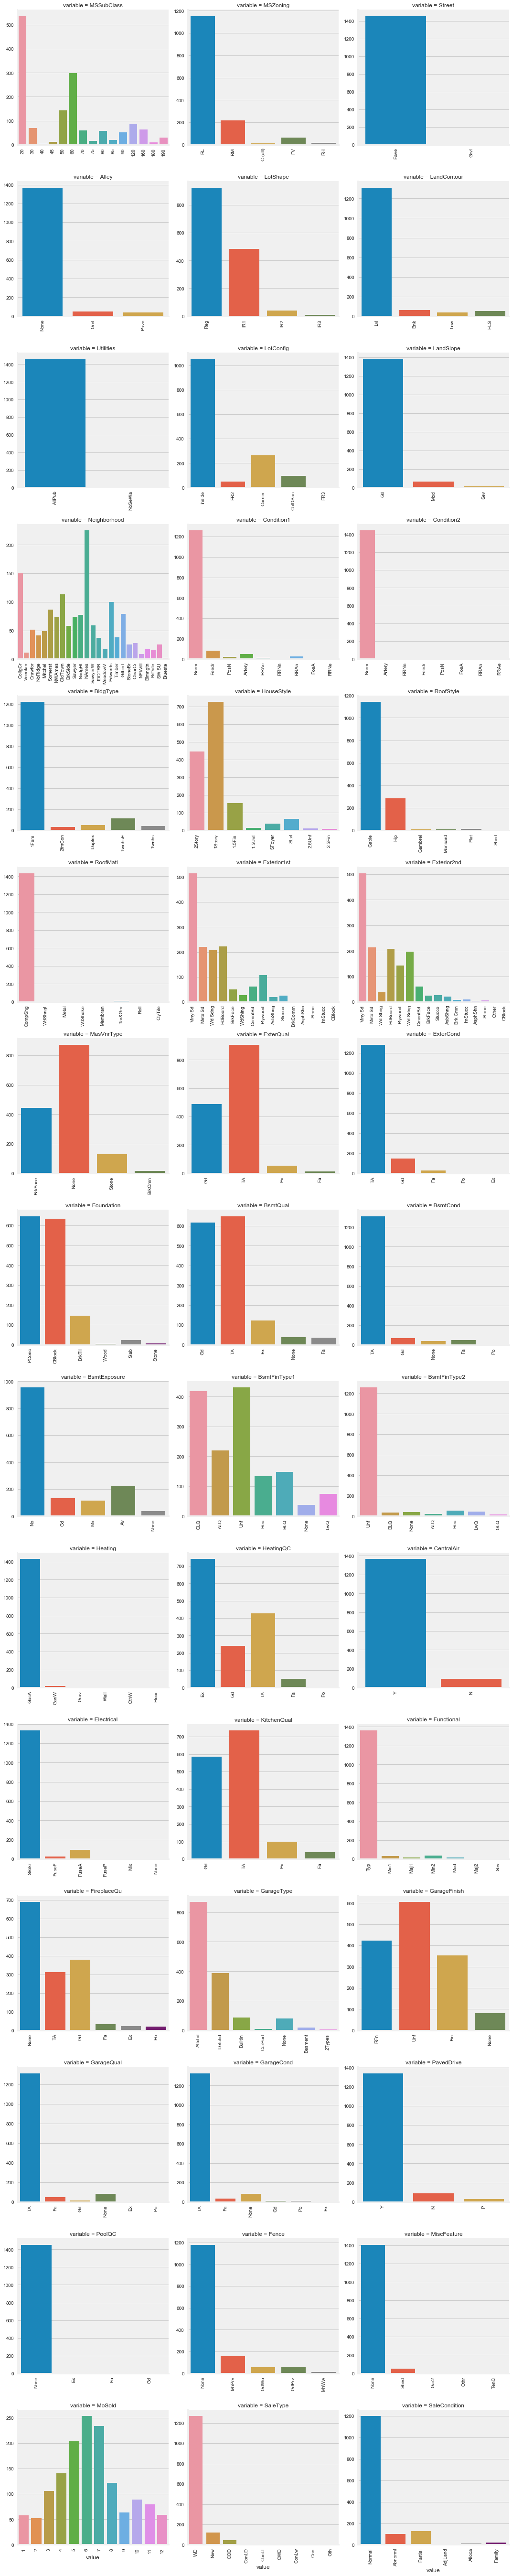

In [23]:
def countplot(x, **kwargs):
    sns.countplot(x=x)
    x=plt.xticks(rotation=90)
f = pd.melt(train, value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(countplot, "value")

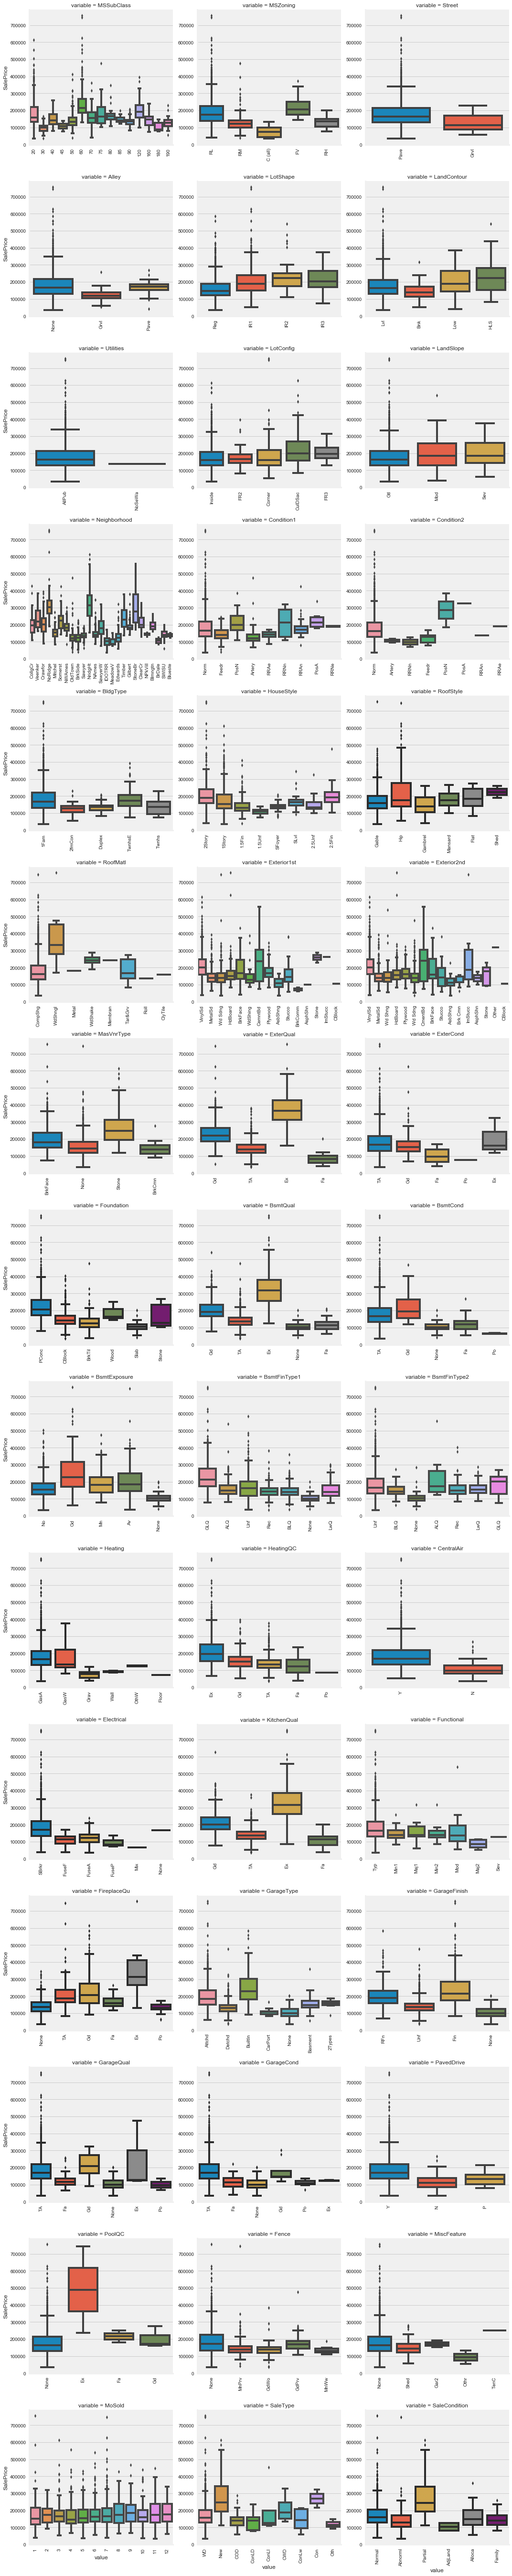

In [24]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

## 2.4.2) Analyse Numeric Data

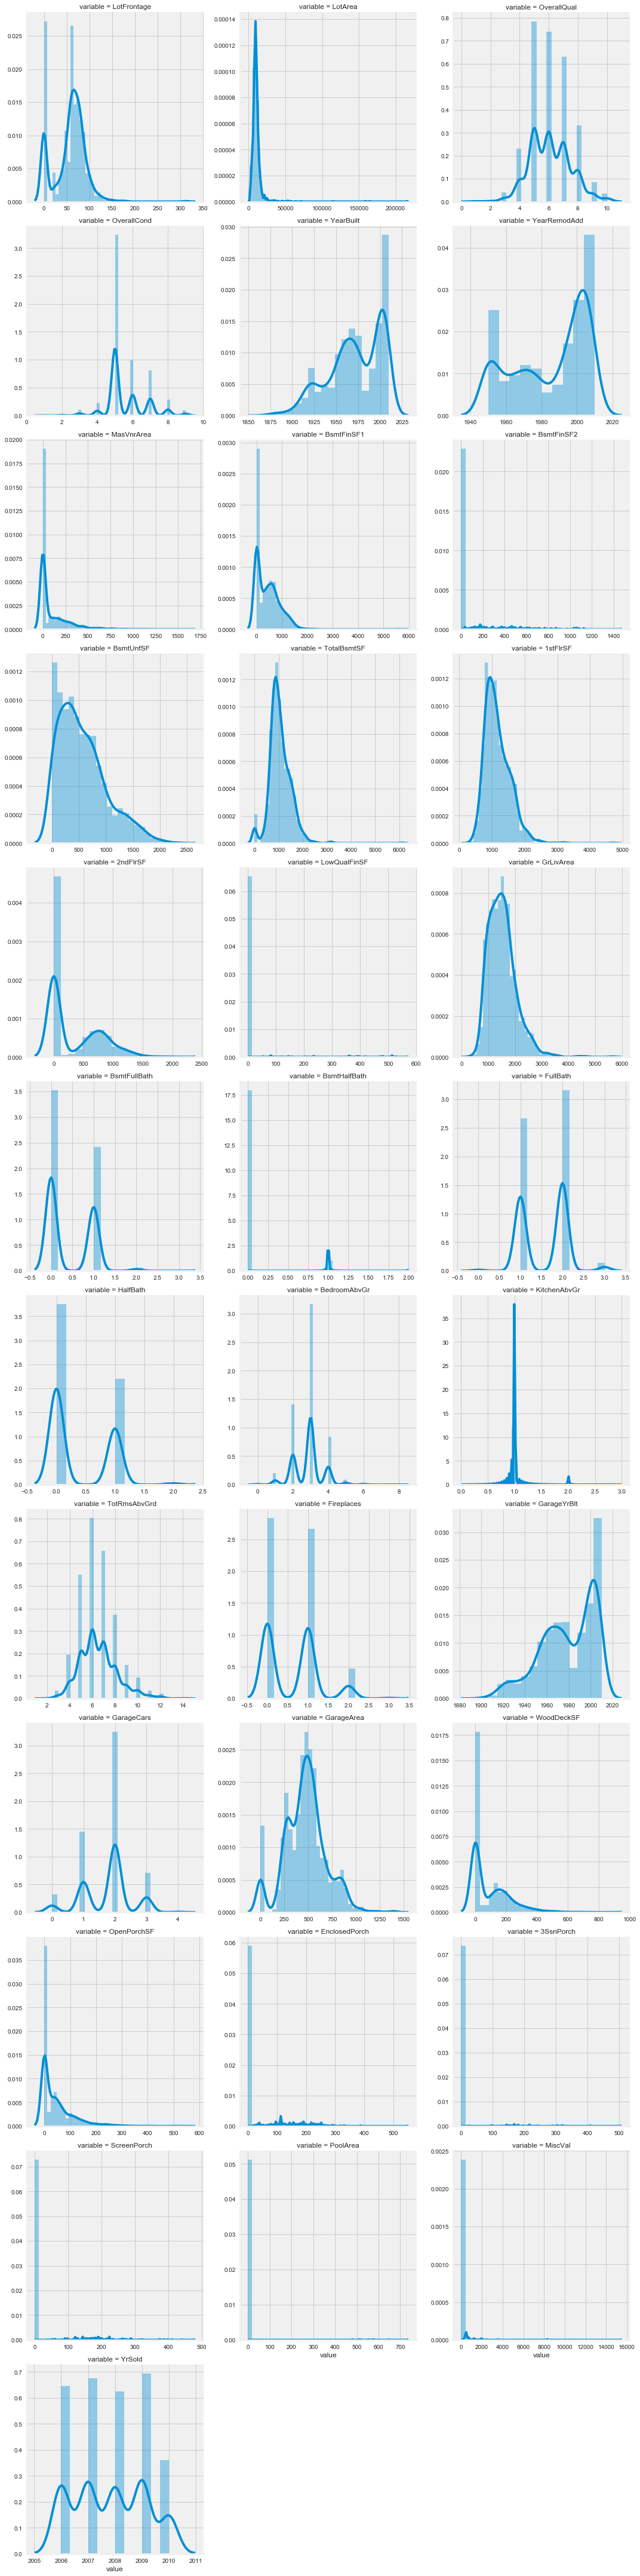

In [25]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(sns.distplot, "value")

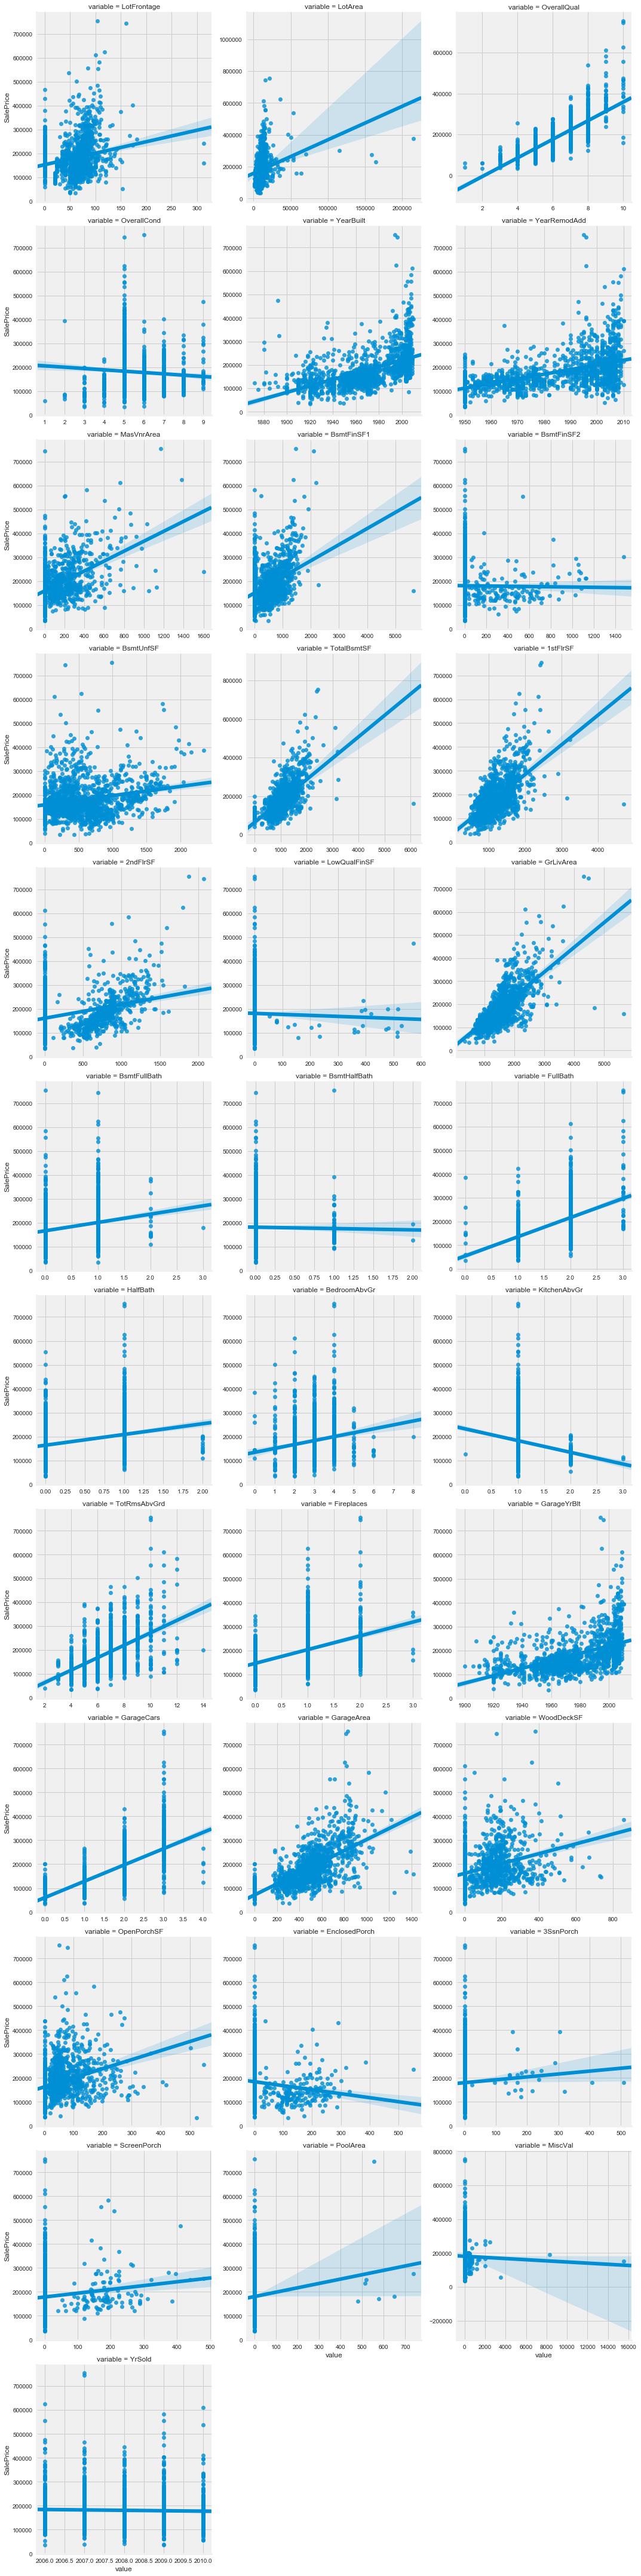

In [26]:
f = pd.melt(train, id_vars=['SalePrice'], value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
#g = g.map(plt.scatter, "value", "SalePrice")
g = g.map(sns.regplot, "value", "SalePrice")

## Update the Dataset

In [27]:
delete_features = ['Street', 
                    'Alley',
                   'LandSlope',
                   'Utilities',
                   'Condition2',
                   'RoofMatl',
                   'Heating',
                   'LowQualFinSF',
                   'KitchenAbvGr',
                   'Functional',
                   '3SsnPorch',
                   'ScreenPorch',
                   'PoolArea',
                   'PoolQC',
                   'MiscFeature',
                   'MiscVal',
                  'Id']

maybe_delete_features = ['LandContour',
                        'Condition1',
                        'OverallCond',
                        'BsmtFinType2',
                        'BsmtFinSF2',
                        'BsmtUnfSF',
                        'GarageQual',
                        'GarageCond',
                        'WoodDeckSF',
                        'OpenPorchSF',
                        'EnclosedPorch',
                        'Fence',
                        'MoSold',
                        'YrSold',
                        'SaleType',
                        'SaleCondition']

**Delete Variables**

In [28]:
train = train.drop(delete_features, axis='columns')
test = test.drop(delete_features, axis='columns')

**Maybe Delete**

In [29]:
#train = train.drop(maybe_delete_features, axis=1)
#test = test.drop(maybe_delete_features, axis=1)

**Delete Outliers**

In [30]:
#train = train[train['LotFrontage'] < 300]
#train = train[train['LotArea'] < 100000]
#train = train[train['BsmtFinSF1'] < 5000]
#train = train[train['TotalBsmtSF'] < 6000]
#train = train[train['1stFlrSF'] < 4000]
#train = train[train['GrLivArea'] < 4500]

**Overwrite Bad Data**

In [31]:
test[test['GarageYrBlt'] == 2207]['GarageYrBlt'] = 2007

## 2.6) Change Categorical Data to Ordinal Data

ExterQual -- dict_num = {'None': 1, 'NA': 1,'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6}
ExterCond -- dict_num = {'None': 1, 'NA': 1,'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6}
BsmtQual -- dict_num = {'None': 1, 'NA': 1,'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6}
BsmtCond -- dict_num = {'None': 1, 'NA': 1,'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6}
BsmtExposure -- dict_num = {'None': 1, 'NA': 1,'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6}
BsmtFinType1 -- dict_num = {'None': 1, 'NA': 1, 'Unf': 2,'LwQ': 3, 'Rec': 4, 'BLQ': 5, 'ALQ': 6, 'GLQ': 7}
BsmtFinType2 -- dict_num = {'None': 1, 'NA': 1, 'Unf': 2,'LwQ': 3, 'Rec': 4, 'BLQ': 5, 'ALQ': 6, 'GLQ': 7}
HeatingQC -- dict_num = {'None': 1, 'NA': 1,'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6}
KitchenQual -- dict_num = {'None': 1, 'NA': 1,'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6}
Functional -- dict_num = {'None': 1, 'NA': 1, 'Sal': 2,'Sev': 3, 'Maj2': 4, 'Maj1': 5, 'Mod': 6, 'Min2': 7, 'Min1': 8, 'Typ': 9}
FireplaceQu -- dict_num = {'None': 1, 'NA': 1,'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6}
GarageFinish -- dict_num = {'None': 1, 'NA': 1,'Unf': 2, 'RFn': 3, 'Fin': 4}   # should this be ordinal?
GarageQual -- dict_num = {'None': 1, 'NA': 1,'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6}
GarageCond -- dict_num = {'None': 1, 'NA': 1,'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6}
PoolQC -- dict_num = {'None': 1, 'NA': 1,'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6}
Fence -- dict_num = {'None': 1, 'NA': 1,'MnWw': 2, 'GdWo': 3, 'MnPrv': 4, ' GdPrv': 5}
LandSlope -- dict_num = {'Gtl': 3, 'Mod': 2, 'Sev': 1}   # should this be ordinal?

dict_num = {'None': 1, 'NA': 1,'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6,
            'Unf': 2,'LwQ': 3, 'Rec': 4, 'BLQ': 5, 'ALQ': 6, 'GLQ': 7,
            'Unf': 2, 'RFn': 3, 'Fin': 4,
            'Sal': 2,'Sev': 3, 'Maj2': 4, 'Maj1': 5, 'Mod': 6, 'Min2': 7, 'Min1': 8, 'Typ': 9,
            'MnWw': 2, 'GdWo': 3, 'MnPrv': 4, 'GdPrv': 5,
            'Sev': 1, 'Mod': 2, 'Gtl': 3,
            'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

#dict_num1 = {'None': 1, 'NA': 1,'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6}
#dict_num2 = {'None': 1, 'NA': 1, 'Unf': 2,'LwQ': 3, 'Rec': 4, 'BLQ': 5, 'ALQ': 6, 'GLQ': 7}
#dict_num3 = {'None': 1, 'NA': 1, 'Unf': 2, 'RFn': 3, 'Fin': 4}
#dict_num4 = {'None': 1, 'NA': 1, 'Sal': 2,'Sev': 3, 'Maj2': 4, 'Maj1': 5, 'Mod': 6, 'Min2': 7, 'Min1': 8, 'Typ': 9}
#dict_num5 = {'None': 1, 'NA': 1,'MnWw': 2, 'GdWo': 3, 'MnPrv': 4, ' GdPrv': 5}
#dict_num6 = {'Sev': 1, 'Mod': 2, 'Gtl': 3}  
#dict_num7 = {'NA': 1, 'No': 1, 'None': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

data_all['ExterQual'] = data_all['ExterQual'].map(dict_num).astype('int')
data_all['ExterCond'] = data_all['ExterCond'].map(dict_num).astype('int')
data_all['BsmtQual'] = data_all['BsmtQual'].map(dict_num).astype('int')
data_all['BsmtCond'] = data_all['BsmtCond'].map(dict_num).astype('int')
data_all['BsmtExposure'] = data_all['BsmtExposure'].map(dict_num).astype('int')
data_all['BsmtFinType1'] = data_all['BsmtFinType1'].map(dict_num).astype('int')
data_all['BsmtFinType2'] = data_all['BsmtFinType2'].map(dict_num).astype('int')
data_all['HeatingQC'] = data_all['HeatingQC'].map(dict_num).astype('int')
data_all['KitchenQual'] = data_all['KitchenQual'].map(dict_num).astype('int')
data_all['Functional'] = data_all['Functional'].map(dict_num).astype('int')
data_all['FireplaceQu'] = data_all['FireplaceQu'].map(dict_num).astype('int')
data_all['GarageFinish'] = data_all['GarageFinish'].map(dict_num).astype('int')
data_all['GarageQual'] = data_all['GarageQual'].map(dict_num).astype('int')
data_all['GarageCond'] = data_all['GarageCond'].map(dict_num).astype('int')
data_all['PoolQC'] = data_all['PoolQC'].map(dict_num).astype('int')
data_all['Fence'] = data_all['Fence'].map(dict_num).astype('int')
data_all['LandSlope'] = data_all['LandSlope'].map(dict_num).astype('int')

# Do the same for train, which is needed for the graphs to work properly
train['ExterQual'] = train['ExterQual'].map(dict_num)
train['ExterCond'] = train['ExterCond'].map(dict_num)
train['BsmtQual'] = train['BsmtQual'].map(dict_num)
train['BsmtCond'] = train['BsmtCond'].map(dict_num)
train['BsmtExposure'] = train['BsmtExposure'].map(dict_num)
train['BsmtFinType1'] = train['BsmtFinType1'].map(dict_num)
train['BsmtFinType2'] = train['BsmtFinType2'].map(dict_num)
train['HeatingQC'] = train['HeatingQC'].map(dict_num)
train['KitchenQual'] = train['KitchenQual'].map(dict_num)
train['Functional'] = train['Functional'].map(dict_num)
train['FireplaceQu'] = train['FireplaceQu'].map(dict_num)
train['GarageFinish'] = train['GarageFinish'].map(dict_num)
train['GarageQual'] = train['GarageQual'].map(dict_num)
train['GarageCond'] = train['GarageCond'].map(dict_num)
train['PoolQC'] = train['PoolQC'].map(dict_num)
train['Fence'] = train['Fence'].map(dict_num)
train['LandSlope'] = train['LandSlope'].map(dict_num)

data_all.info()

# 3) EDA

This is all done just on the training data.

quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

data_all[data_all['dataset']=='test'].shape

## 3.1) Sales Price

plt.figure(figsize=(10,6))
sns.distplot(train['SalePrice'])
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(train['SalePrice'])
plt.show()

print('Outliers have a price greater than', np.percentile(train['SalePrice'], 75) + 1.5*(np.percentile(train['SalePrice'], 75) - np.percentile(train['SalePrice'], 25)))

## 3.2) Univariate EDA of Numeric Data

f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, size=5)
g = g.map(sns.distplot, "value")

## 3.3) Univariate EDA of Categorical Data

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

## 3.4) Correlation Matrix

Let's see which variables have a high linear correlation with SalePrice.

# Correlation Matrix

# Compute the correlation matrix
d= train
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, 
            square=True, linewidths=.5, annot=False, cmap=cmap)
plt.yticks(rotation=0)
plt.title('Correlation Matrix of all Numerical Variables')
plt.show()

The highest correlations with SalePrice are

1) OverallQual
<br>
2) GrLivArea
<br>
3) GarageArea
<br>
4) GarageCars
<br>
5) TotalBsmtSF
<br>
6) 1stFlrSF
<br>
7) FullBath
<br>
8) TotRmsAbvGrd
<br> 
9) YearBuilt
<br>
10) YearRemodAdd 

corr.loc['SalePrice'][0:].sort_values()

# 4) Prepare the Data

In [32]:
# Make copy of all_data to check where errors occur
#data_copy = data_all

print('train:',data_all[data_all['dataset'] == 'train'].shape)
print('test:',data_all[data_all['dataset'] == 'test'].shape)

data_all.info()

## Delete Outliers

In [33]:
# I didn't include SalePrice in data_all because there is no data in test. I will exclude the outliers below when dealing
# with the SalePrice in train
#data_all = data_all[(data_all['dataset'] == 'test') | ((data_all['dataset'] == 'train') & (data_all['GrLivArea'] < 4675))]

print('train:',data_all[data_all['dataset'] == 'train'].shape)
print('test:',data_all[data_all['dataset'] == 'test'].shape)

data_all.info()

## Create New Features

#data_all['TotalSF'] = data_all['TotalBsmtSF'] + data_all['1stFlrSF'] + data_all['2ndFlrSF']

data_all['Total_sqr_footage'] = (data_all['BsmtFinSF1'] + data_all['BsmtFinSF2'] +
                                 data_all['1stFlrSF'] + data_all['2ndFlrSF'])

data_all['Total_Bathrooms'] = (data_all['FullBath'] + (0.5*data_all['HalfBath']) + 
                               data_all['BsmtFullBath'] + (0.5*data_all['BsmtHalfBath']))

data_all['Total_porch_sf'] = (data_all['OpenPorchSF'] + data_all['3SsnPorch'] +
                              data_all['EnclosedPorch'] + data_all['ScreenPorch'] +
                             data_all['WoodDeckSF'])


#simplified features
data_all['haspool'] = data_all['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data_all['has2ndfloor'] = data_all['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
data_all['hasgarage'] = data_all['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
data_all['hasbsmt'] = data_all['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data_all['hasfireplace'] = data_all['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


## 4.1) Take Log of Sale Price - Dependent Variable

# log transform the target
#data_all_2 = data_all_1[(data_all_1['dataset'] == 'test') | ((data_all_1['dataset'] == 'train') & (data_all_1['SalePrice'] < 340037))]
data_all_2 = data_all

print('train:',data_all_2[data_all_2['dataset'] == 'train'].shape)
print('test:',data_all_2[data_all_2['dataset'] == 'test'].shape)

data_all_2.info()

data_all_2.head()

# Reset the index
data_all_2 = data_all_2.reindex()

data_all_2['SalePrice'] = np.log1p(data_all_2['SalePrice'])
data_all = data_all_2

data_all[data_all['dataset'] == 'test'].shape

In [34]:
# Take the log Sale Price
train['SalePrice'] = np.log1p(train['SalePrice'])

## Scaling Data - not done yet

# Additional processing: scale the data. -- Try on different versions: Box-Cox, StandardScaler etc.  
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_df_munged[numeric_features])

scaled = scaler.transform(train_df_munged[numeric_features])
for i, col in enumerate(numeric_features):
    train_df_munged[col] = scaled[:, i]

scaled = scaler.transform(test_df_munged[numeric_features])
for i, col in enumerate(numeric_features):
    test_df_munged[col] = scaled[:, i]

## 4.2) Take Log of Numeric Variables - Independent Variables

I only take the log if the skew is above a certain threshold - here it is 0.5. This is based on the interpretations from here: https://brownmath.com/stat/shape.htm

In [35]:
# Log of numeric variables and show which features are the most skewed

numeric_features = train.dtypes[train.dtypes != 'object'].index

skewed_features = train[numeric_features].apply(lambda x: skew(x))
np.abs(skewed_features).sort_values(ascending=False)

LotArea          12.195142
BsmtFinSF2        4.250888
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.674865
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
1stFlrSF          1.375342
GrLivArea         1.365156
BsmtUnfSF         0.919323
2ndFlrSF          0.812194
OverallCond       0.692355
TotRmsAbvGrd      0.675646
HalfBath          0.675203
Fireplaces        0.648898
YearBuilt         0.612831
BsmtFullBath      0.595454
YearRemodAdd      0.503044
GarageCars        0.342197
LotFrontage       0.267547
OverallQual       0.216721
BedroomAbvGr      0.211572
GarageArea        0.179796
SalePrice         0.121222
YrSold            0.096170
FullBath          0.036524
GarageYrBlt            NaN
dtype: float64

In [36]:
# Continue taking the log when skewness > 0.5

skewed_features = skewed_features[skewed_features > 0.5]
skewed_features = skewed_features.index

train[skewed_features] = np.log1p(train[skewed_features])
test[skewed_features] = np.log1p(test[skewed_features])

## 4.3) Get Dummy Variables

In [37]:
data_one_hot = pd.get_dummies(train)
data_one_hot.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,YrSold,SalePrice,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_None,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSo

In [38]:
data_one_hot_train = pd.get_dummies(train)
data_one_hot_test = pd.get_dummies(test)

Let's check which dummy variables are quite imbalanced. These are all the classes within an object variable. As we saw some classes were essentially superfluous. I am checking where the transactions within one class make up less than 1 percent of all transactions. 
<br>
**Should this be done only on train data? What happens to cases where test data contains those fields? How should they be overridden? It's probably enough to just drop the column also from test data after it has been turned into a dummy variable.**

In [39]:
overfit = []
for i in data_one_hot.columns:
    counts = data_one_hot[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(data_one_hot) * 100 >99:
        overfit.append(i)

In [40]:
overfit = list(overfit)
overfit

['MSSubClass_40',
 'MSSubClass_45',
 'MSSubClass_180',
 'MSZoning_C (all)',
 'LotShape_IR3',
 'LotConfig_FR3',
 'Neighborhood_Blueste',
 'Neighborhood_NPkVill',
 'Neighborhood_Veenker',
 'Condition1_PosA',
 'Condition1_RRAe',
 'Condition1_RRNe',
 'Condition1_RRNn',
 'HouseStyle_1.5Unf',
 'HouseStyle_2.5Fin',
 'HouseStyle_2.5Unf',
 'RoofStyle_Flat',
 'RoofStyle_Gambrel',
 'RoofStyle_Mansard',
 'RoofStyle_Shed',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior1st_CBlock',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_AsphShn',
 'Exterior2nd_Brk Cmn',
 'Exterior2nd_CBlock',
 'Exterior2nd_ImStucc',
 'Exterior2nd_Other',
 'Exterior2nd_Stone',
 'ExterQual_Fa',
 'ExterCond_Ex',
 'ExterCond_Po',
 'Foundation_Stone',
 'Foundation_Wood',
 'BsmtCond_Po',
 'BsmtFinType2_GLQ',
 'HeatingQC_Po',
 'Electrical_FuseP',
 'Electrical_Mix',
 'Electrical_None',
 'GarageType_2Types',
 'GarageType_CarPort',
 'GarageQual_Ex',
 'GarageQual_Gd',
 'GarageQual_Po',
 'GarageCond_Ex',
 'Garag

## 4.4) Split Into Test and Train

X_train = data_one_hot[data_one_hot['dataset_train'] == 1].drop(columns=['dataset_test', 'dataset_train', 'SalePrice', 'Id'])
X_test = data_one_hot[data_one_hot['dataset_test'] == 1].drop(columns=['dataset_test', 'dataset_train', 'SalePrice', 'Id'])
y_train = data_all[data_all['dataset'] == 'train']['SalePrice']

X_test_Id = pd.DataFrame()
X_test_Id['Id'] =  data_one_hot[data_one_hot['dataset_test'] == 1]['Id']

In [41]:
X_train = data_one_hot_train.drop('SalePrice', axis='columns')
X_test = data_one_hot_test
y_train = train['SalePrice']

In [42]:
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)

X_train: (1460, 274)
X_test: (1459, 269)
y_train: (1460,)


In [43]:
X_train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,YrSold,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_None,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSol

In [44]:
X_test.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,YrSold,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleTyp

In [45]:
X_train.columns[X_train.columns.isin(X_test.columns) == False]

Index(['HouseStyle_2.5Fin', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
       'Electrical_Mix', 'Electrical_None', 'GarageQual_Ex'],
      dtype='object')

In [46]:
X_train = X_train.drop('GarageYrBlt', axis='columns')
X_test = X_test.drop('GarageYrBlt', axis='columns')

In [47]:
X_train = X_train.drop(['HouseStyle_2.5Fin', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
       'Electrical_Mix'], axis='columns')

In [48]:
X_test = X_test.drop('MSSubClass_150', axis='columns')

In [49]:
X_train = X_train.drop(['Electrical_None', 'GarageQual_Ex'], axis='columns')

# 5) Run Models

## Random Forest Regression

In [50]:
rf_reg = RandomForestRegressor(n_estimators=100,
                              random_state=1)
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_train)
cv_scores_rf = cross_val_score(rf_reg, X_train, y_train, cv=5)

In [51]:
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores_rf)))
# Print the 5-fold cross-validation scores
print(cv_scores_rf)

Average 5-Fold CV Score: 0.869372981706437
[0.86990805 0.86718589 0.87036733 0.88173678 0.85766686]


In [52]:
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 0.05300394313384433


Feature Importance

In [53]:
importance = pd.DataFrame(list(zip(X_train.columns, np.transpose(rf_reg.feature_importances_))) \
            ).sort_values(1, ascending=False)
importance

,0,1
2,OverallQual,5.549577e-01
13,GrLivArea,1.133706e-01
10,TotalBsmtSF,4.486450e-02
21,GarageCars,3.994743e-02
11,1stFlrSF,2.407073e-02
7,BsmtFinSF1,2.239764e-02
22,GarageArea,2.221600e-02
4,YearBuilt,1.597424e-02
1,LotArea,1.406268e-02
3,OverallCond,1.121704e-02


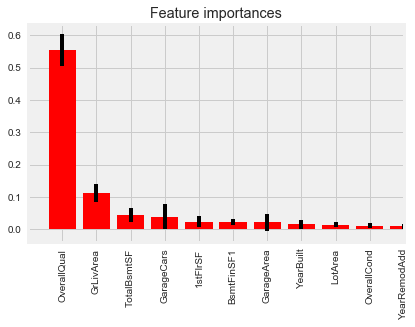

In [54]:
importances = rf_reg.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf_reg.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],  
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]),X_train.columns[indices], rotation=90)
#plt.xlim([-1, X_train_s.shape[1]])
plt.xlim([-1, 10])
plt.show()

## Random Forest GridSearch

In [55]:
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [56]:
#from sklearn.model_selection import GridSearchCV

#param_grid = [{'max_depth': range(20,31,2), #[20,22,24,26,28,30], 
#               'max_features': range(35,55,5), #[35,40,45,50],
#               'min_samples_leaf': [1,5,10],
#               'n_estimators': [100],
#               'random_state': [1]}]

#rf_grid = RandomForestRegressor()

#grid_search_rf = GridSearchCV(rf_grid, param_grid, cv=5, scoring='neg_mean_squared_error')

#grid_search_rf.fit(X_train, y_train)

#grid_search_rf.best_params_

In [57]:
rf_grid = RandomForestRegressor(n_estimators=1000,
                                max_depth=26, #16
                                max_features=40, #30
                                min_samples_leaf=10, # using 5 doesn't seem to improve things
                                random_state=1)
rf_grid.fit(X_train, y_train)
y_pred_grid = rf_grid.predict(X_train)
cv_scores_rf_grid = cross_val_score(rf_grid, X_train, y_train, cv=5)

In [58]:
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores_rf_grid)))
# Print the 5-fold cross-validation scores
print(cv_scores_rf_grid)

Average 5-Fold CV Score: 0.8510943489245054
[0.87218077 0.84894673 0.84018801 0.85180594 0.8423503 ]


In [59]:
rmse = np.sqrt(mean_squared_error(y_train, y_pred_grid))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 0.1288190986110784


## LassoLarsCV

In [60]:
from sklearn.linear_model import LassoLarsCV

lasso = LassoLarsCV(normalize=True)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_train) #here not X_test used because somehow it doesn't work due to different array lengths
cv_scores_lasso = cross_val_score(lasso, X_train, y_train, cv=5)

In [61]:
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores_lasso)))
# Print the 5-fold cross-validation scores
print(cv_scores_lasso)

Average 5-Fold CV Score: 0.8859597103866024
[0.91821797 0.89800235 0.86460175 0.88451143 0.86446506]


In [62]:
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 0.11496635340540572


## LassoLarsCV Gridsearch

In [63]:
#from sklearn.model_selection import GridSearchCV

#param_grid = [{'normalize': [True, False], 'fit_intercept': [True, False], 'max_iter': [100,200,300,400,500,600,700,800,900,1000],
#              'max_n_alphas': [500, 750, 1000, 1250, 1500]}]

#lars_grid = LassoLarsCV()

#grid_search_lars = GridSearchCV(lars_grid, param_grid, cv=5, scoring='neg_mean_squared_error')

#grid_search_lars.fit(X_train, y_train)

#grid_search_lars.best_params_

In [64]:
from sklearn.linear_model import LassoLarsCV

lars_grid = LassoLarsCV(normalize=False, fit_intercept=False, max_iter=200, max_n_alphas=500)
lars_grid.fit(X_train, y_train)

y_pred_grid = lars_grid.predict(X_train) #here not X_test used because somehow it doesn't work due to different array lengths
cv_scores_lars_grid = cross_val_score(lars_grid, X_train, y_train, cv=5)

In [65]:
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores_lars_grid)))
# Print the 5-fold cross-validation scores
print(cv_scores_lars_grid)

Average 5-Fold CV Score: 0.9004315888088325
[0.9219892  0.89931776 0.90068327 0.91452131 0.8656464 ]


In [66]:
rmse = np.sqrt(mean_squared_error(y_train, y_pred_grid))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 0.11291973956578662


## XGBoost

More on parameters and tuning here: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [67]:
import xgboost as xgb

xgb = xgb.XGBRegressor(
                 colsample_bytree=0.2,  # fraction of features used in tree
                 gamma=0.0,             # node is only split if there is a positive loss reduction
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,  # Defines the minimum sum of weights of all observations required in a child. Larger numbers more conservative but can lead to underfitting
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,         # L1 regularization term on weight (analogous to Lasso regression
                 reg_lambda=0.6,        # L2 regularization term on weights (analogous to Ridge regression
                 subsample=0.2,         #very small number, maybe should be increased to 0.5-1
                 seed=42,
                 silent=0)              # supposed to give out messages. previously 1

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_train)
cv_scores_xgb = cross_val_score(xgb, X_train, y_train, cv=5)

In [68]:
print("Average 5-fold CV Score: {}".format(np.mean(cv_scores_xgb)))
# Print the 5-fold cross-validation scores
print(cv_scores_xgb)

Average 5-fold CV Score: 0.9047227107897399
[0.9158816  0.90287837 0.89828069 0.91629851 0.89027438]


In [69]:
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 0.0756959075480486


## XGBoost GridSearch

In [70]:
#import xgboost as xgb
#xgb.XGBRegressor().get_params().keys()

from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = [{'colsample_bylevel': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], 
               'gamma': [0,0.5,1,2,3,4],
              'learning_rate': [0.005,0.01,0.15,0.02,0.3],
              'max_depth': [2,3,4,5,6,7,8],
              'min_child_weight': [1.5],
              'n_estimators': [7200],
              'reg_alpha': [0.9],
              'reg_lambda': [0.6],
              'subsample': [0.2, 0.5,0.75],
              'seed': [42],
              'silent': [1]}]

xgb_grid = xgb.XGBRegressor()

grid_search_xgb = GridSearchCV(xgb_grid, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search_xgb.fit(X_train, y_train)

grid_search_xgb.best_params_

## XGBoost GridSearch 2

def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds, verbose_eval=False) #, show_progress=False
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], y_train, eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    #print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    #print ("RMSE Score (Train): %f" % metrics.mean_squared_error(dtrain['Disbursed'], dtrain_predprob))
    print ("RMSE Score (Train): %f" % metrics.mean_squared_error(y_train, dtrain_predictions))
    print ("R2 Score (Train): %f" % metrics.r2_score(y_train, dtrain_predictions))
                    
    #feat_imp = pd.Series(xgb.alg.Booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    xgb.plot_importance(alg, title='Feature Importance', xlabel='F Score', ylabel='Features', importance_type='weight',
                       max_num_features=15, show_values=False)
    #plt.ylabel('Feature Importance Score')

import xgboost as xgb

#Choose all predictors
predictors = [x for x in X_train.columns]
xgb1 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=1)
modelfit(xgb1, X_train, predictors)

**Max_Depth and Min_Child_Weight**

n_estimators=343

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=343, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, 
 nthread=4, scale_pos_weight=1, seed=1), 
 param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Max_Depth: 3, Min_Child_weight: 5 -- I did a further GridSearch and got the same result

**Gamma**

param_test2 = {
 'gamma': [i/10.0 for i in range(0,6)]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=343, max_depth=3,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8, 
 nthread=4, scale_pos_weight=1, seed=1), 
 param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Gamma = 0

import xgboost as xgb

#Choose all predictors
predictors = [x for x in X_train.columns]
xgb2 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=1)
modelfit(xgb2, X_train, predictors)

n_estimators = 446

**Subsample and Colsample_Bytree**

param_test3 = {
 'subsample': [0.9],
 'colsample_bytree': [i/10.0 for i in range(1,7)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=446, max_depth=3,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8, 
 nthread=4, scale_pos_weight=1, seed=1), 
 param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

'colsample_bytree': 0.6, 'subsample': 0.9

**Regularisation Parameter**

param_test4 = {
 'reg_alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=446, max_depth=3,
 min_child_weight=5, gamma=0, subsample=0.9, colsample_bytree=0.6, 
 nthread=4, scale_pos_weight=1, seed=1), 
 param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train, y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

'reg_alpha': 0.001

import xgboost as xgb

#Choose all predictors
predictors = [x for x in X_train.columns]
xgb3 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=5,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.6,
 nthread=4,
 scale_pos_weight=1,
 reg_alpha=0.001,
 seed=1)
modelfit(xgb3, X_train, predictors)

n_estimators=447

**Learning Rate**

import xgboost as xgb

#Choose all predictors
predictors = [x for x in X_train.columns]
xgb4 = xgb.XGBRegressor(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=5,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.6,
 nthread=4,
 scale_pos_weight=1,
 reg_alpha=0.001,
 seed=1)
modelfit(xgb4, X_train, predictors)

import xgboost as xgb

#Choose all predictors
predictors = [x for x in X_train.columns]
xgb5 = xgb.XGBRegressor(
 learning_rate =0.001,
 n_estimators=50000,
 max_depth=3,
 min_child_weight=5,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.6,
 nthread=4,
 scale_pos_weight=1,
 reg_alpha=0.001,
 seed=1)
modelfit(xgb5, X_train, predictors)

xgb4 seems best

import xgboost as xgb

xgb4 = xgb.XGBRegressor(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=5,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.6,
 nthread=4,
 scale_pos_weight=1,
 reg_alpha=0.001,
 seed=1)

xgb4.fit(X_train, y_train)

xgb4.fit(X_train, y_train)

y_pred = xgb4.predict(X_train)
cv_scores_xgb4 = cross_val_score(xgb4, X_train, y_train, cv=5, scoring='r2')

print("Average 5-fold CV Score: {}".format(np.mean(cv_scores_xgb5)))
# Print the 5-fold cross-validation scores
print(cv_scores_xgb4)

rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

## Lasso

In [71]:
from sklearn.linear_model import Lasso

# I found this best alpha through cross-validation.
best_alpha = 0.00099

lasso_regr = Lasso(alpha=best_alpha, max_iter=50000)
lasso_regr.fit(X_train, y_train)

y_pred = lasso_regr.predict(X_train)
cv_scores_lasso_regr = cross_val_score(lasso_regr, X_train, y_train, cv=5)

In [72]:
print("Average 5-fold CV Score: {}".format(np.mean(cv_scores_lasso_regr)))
# Print the 5-fold cross-validation scores
print(cv_scores_lasso_regr)

Average 5-fold CV Score: 0.8989206849158986
[0.92176214 0.89783759 0.90068142 0.91381933 0.86050294]


In [73]:
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 0.11651209448558152


## Lasso GridSearch

In [74]:
#from sklearn.model_selection import GridSearchCV

#param_grid = [{'alpha': [0.01, 0.05, 0.07, 0.1, 0.15, 0.2], 'fit_intercept': [True,False], 'normalize': [True,False],
#              'max_iter': [100,400,800,1200,1600], 'random_state': [1]}]

#lasso_grid = Lasso()

#grid_search_lasso = GridSearchCV(lasso_grid, param_grid, cv=5, scoring='neg_mean_squared_error')

#grid_search_lasso.fit(X_train, y_train)

#grid_search_lasso.best_params_

In [75]:
from sklearn.linear_model import Lasso

# I found this best alpha through cross-validation.
best_alpha = 0.00099

lasso_grid = Lasso(alpha=0.0001, max_iter=100, random_state=1)
lasso_grid.fit(X_train, y_train)

y_pred_grid = lasso_grid.predict(X_train)
cv_scores_lasso_grid = cross_val_score(lasso_grid, X_train, y_train, cv=5)

In [76]:
print("Average 5-fold CV Score: {}".format(np.mean(cv_scores_lasso_grid)))
# Print the 5-fold cross-validation scores
print(cv_scores_lasso_grid)

Average 5-fold CV Score: 0.892433329323441
[0.9144592  0.89778134 0.88869072 0.90323064 0.85800475]


In [77]:
rmse = np.sqrt(mean_squared_error(y_train, y_pred_grid))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 0.10602838917095074


# 6. Make Prediction on Test Set and Create CSV to be Submitted

In [78]:
# testing gridsearch
#y_pred_test = xgb1.predict(X_test) # this used to be rf_reg

In [79]:

# Gridsearch improved the score - Uncomment and use this one as best submission
y_pred_test = (xgb.predict(X_test) + lasso.predict(X_test) + lasso_regr.predict(X_test)) / 3 

# Alternative Weigting
#y_pred_test = 0*xgb.predict(X_test) + 0.5*lars_grid.predict(X_test) + 0.5*lasso_grid.predict(X_test) 

# I tried including RandomForest. It didn't improve the score

In [80]:
submission = pd.DataFrame({'Id': test.Id, 'SalePrice': np.expm1(y_pred_test)})
submission.to_csv('submission_ames.csv', index=False)
submission.shape

AttributeError: 'DataFrame' object has no attribute 'Id'

In [81]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,Fence,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,9.360741,Reg,Lvl,Inside,NAmes,Feedr,1Fam,1Story,5.0,1.945910,1961.0,1961.0,Gable,VinylSd,VinylSd,None,0.000000,TA,TA,CBlock,TA,TA,No,Rec,6.150603,LwQ,4.976734,5.602119,6.783325,TA,Y,SBrkr,6.799056,0.000000,6.799056,0.0,0.0,1.0,0.000000,2.0,TA,1.791759,0.000000,None,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,4.948760,0.000000,0.0,MnPrv,6,2010.0,WD,Normal
1,20,RL,81.0,9.565775,IR1,Lvl,Corner,NAmes,Norm,1Fam,1Story,6.0,1.945910,1958.0,1958.0,Hip,Wd Sdng,Wd Sdng,BrkFace,4.691348,TA,TA,CBlock,TA,TA,No,ALQ,6.828712,Unf,0.000000,6.008813,7.192934,TA,Y,SBrkr,7.192934,0.000000,7.192934,0.0,0.0,1.0,0.693147,3.0,Gd,1.945910,0.000000,None,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,5.976351,3.610918,0.0,None,6,2010.0,WD,Normal
2,60,RL,74.0,9.534668,IR1,Lvl,Inside,Gilbert,Norm,1Fam,2Story,5.0,1.791759,1997.0,1998.0,Gable,VinylSd,VinylSd,None,0.000000,TA,TA,PConc,Gd,TA,No,GLQ,6.674561,Unf,0.000000,4.927254,6.834109,Gd,Y,SBrkr,6.834109,6.553933,7.396335,0.0,0.0,2.0,0.693147,3.0,TA,1.945910,0.693147,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,5.361292,3.555348,0.0,MnPrv,3,2010.0,WD,Normal
3,60,RL,78.0,9.208238,IR1,Lvl,Inside,Gilbert,Norm,1Fam,2Story,6.0,1.945910,1998.0,1998.0,Gable,VinylSd,VinylSd,BrkFace,3.044522,TA,TA,PConc,TA,TA,No,GLQ,6.401917,Unf,0.000000,5.783825,6.831954,Ex,Y,SBrkr,6.831954,6.520621,7.380879,0.0,0.0,2.0,0.693147,3.0,Gd,2.079442,0.693147,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,5.888878,3.610918,0.0,None,6,2010.0,WD,Normal
4,120,RL,43.0,8.518392,IR1,HLS,Inside,StoneBr,Norm,TwnhsE,1Story,8.0,1.791759,1992.0,1992.0,Gable,HdBoard,HdBoard,None,0.000000,Gd,TA,PConc,Gd,TA,No,ALQ,5.575949,Unf,0.000000,6.925595,7.155396,Ex,Y,SBrkr,7.155396,0.000000,7.155396,0.0,0.0,2.0,0.000000,2.0,Gd,1.791759,0.000000,None,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0.000000,4.418841,0.0,None,1,2010.0,WD,Normal
